# Classification Project w/ OOP

Please fill out:
* Student name: Wayne Lam
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: Sean Abu
* Blog post URL:


## Import Modules, Packages, and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm

import classification_funcs as cl_f

pd.set_option('display.max_columns', 300)

/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Data from https://www.kaggle.com/becksddf/churn-in-telecoms-dataset
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head(3)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


### Comments on Initial DataFrame Features
- Area code: convert to categorical and dummy
- Int./VM plans: convert to dummies
- State: convert to categorical and dummy

In [3]:
# Dropping identifying info that is irrelevent
df.drop('phone number', axis=1, inplace=True)

## EDA

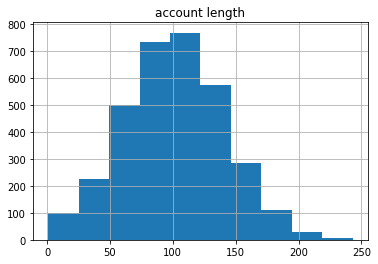

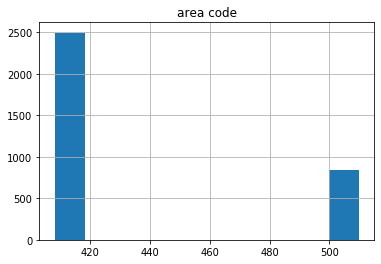

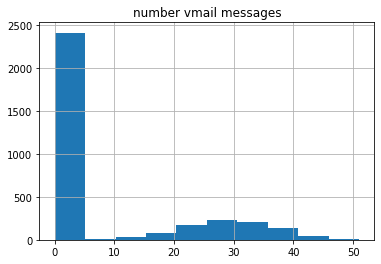

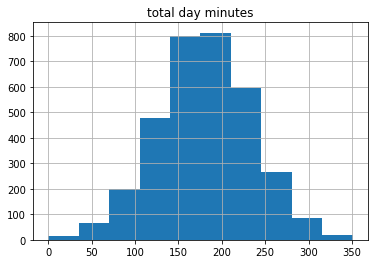

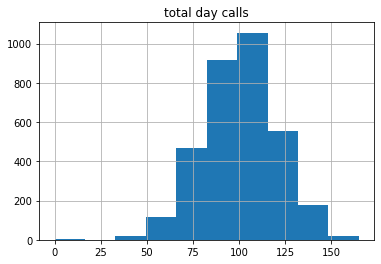

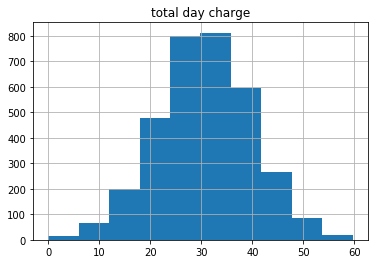

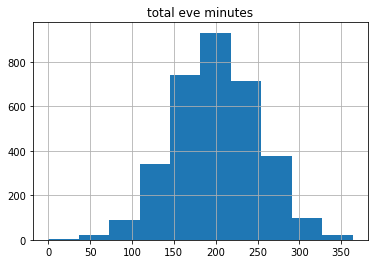

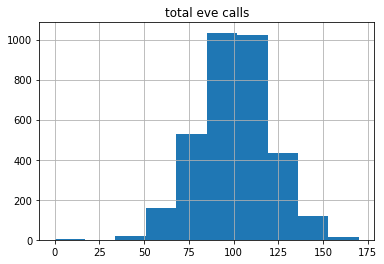

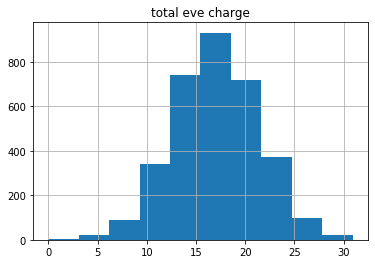

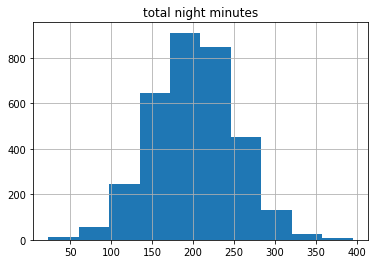

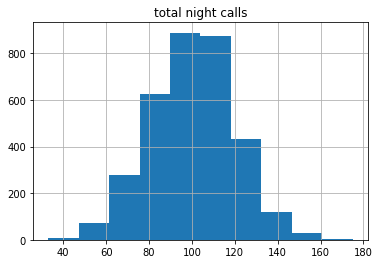

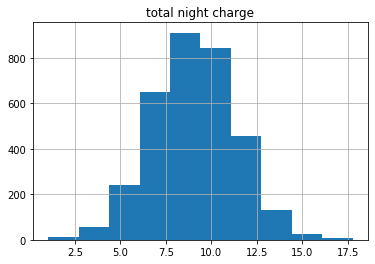

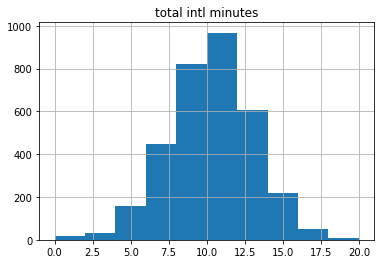

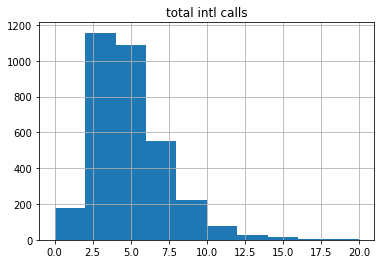

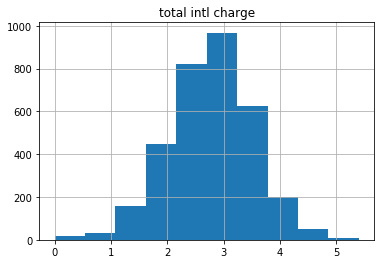

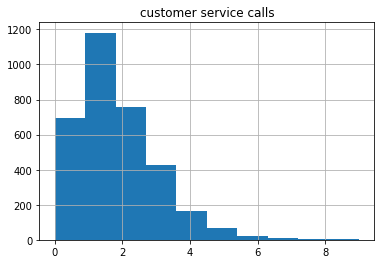

In [4]:
# Plot histograms of continuous/"semi-continuous" features
cl_f.multi_plot(df, plot='hist', target='churn')

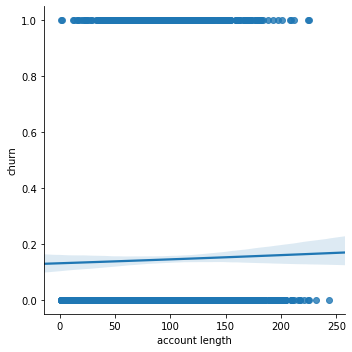

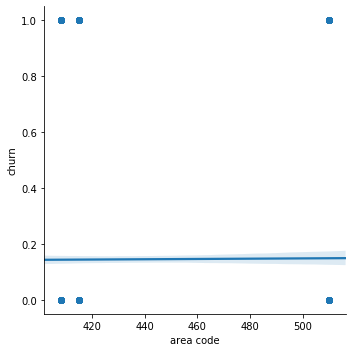

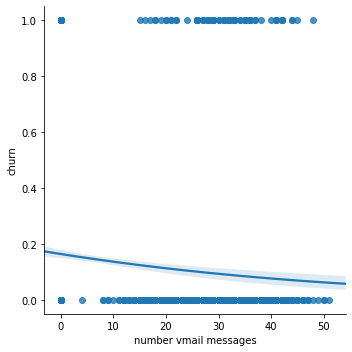

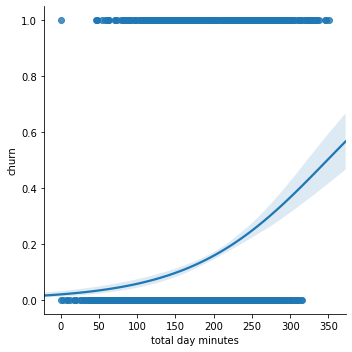

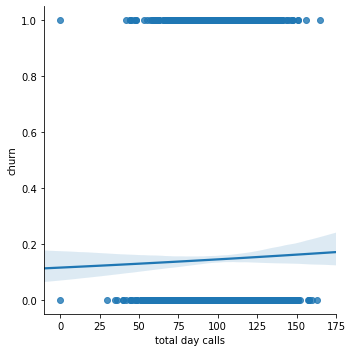

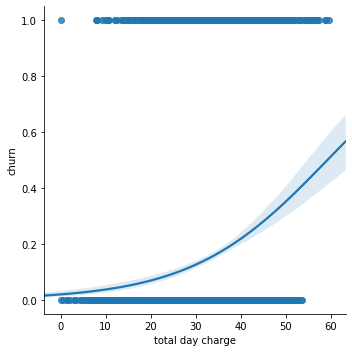

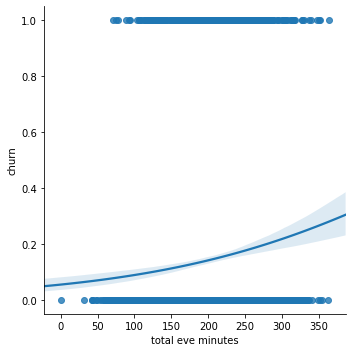

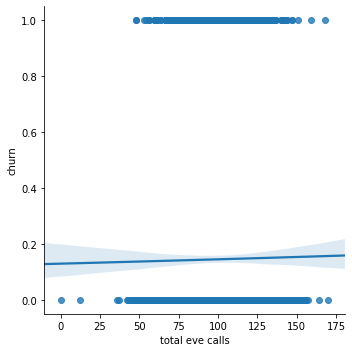

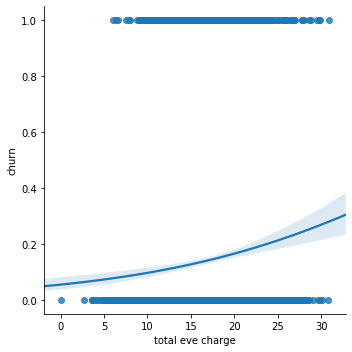

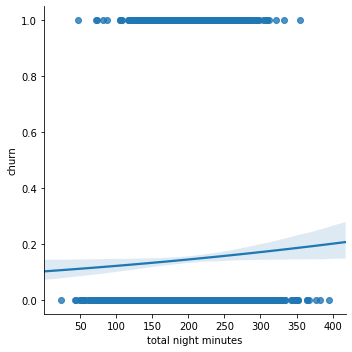

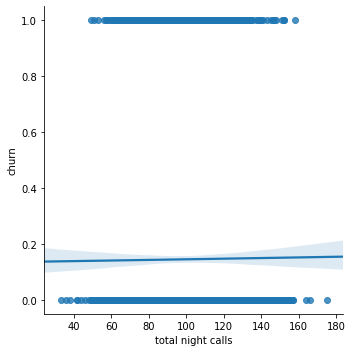

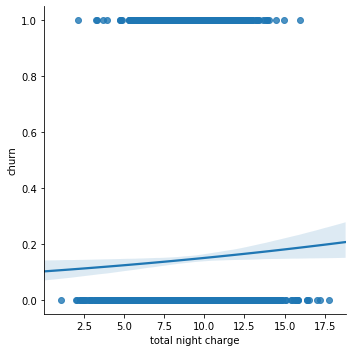

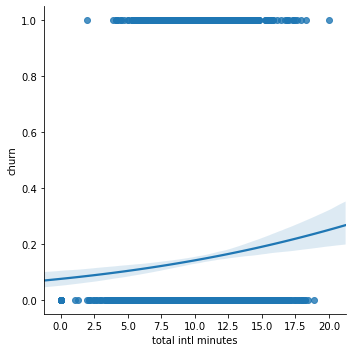

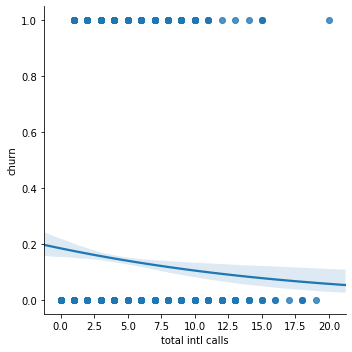

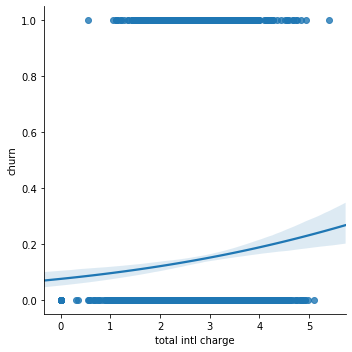

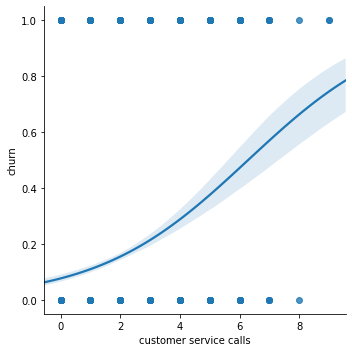

In [5]:
# Plot LM plots of continuous/"semi-continuous" features in relation to churn rate
cl_f.multi_plot(df, plot='lmplot', target='churn')

### Comments on Initial EDA
- Number vmail messages: Stat test churn rate of no vm and has vm (chi-squared)
- Total intl calls: right skew
- Customer service calls: right skew
- Total calls (internation, evening, night) do not appear to increase churn rate
- Total minutes and charges seem to increase churn rate:
    Likely that individuals who make long calls want unlimited minutes plans

In [6]:
# Null hypothesis: churn rate of (VM Messages = 0) = churn rate of (VM Messages > 0), alpha = 0.05
cl_f.chi_sq(df, feature='number vmail messages', target='churn')

Reject Null Hypothesis
Chi-Squared: 34.77733072701296
p-value: 2.8067167404597397e-08


### Comments on Chi-Squared Test of VM Messages
- There appears to be a relationship between 0 VM messages or >0 VM messages with respect to churn rate
- Bin VM messages

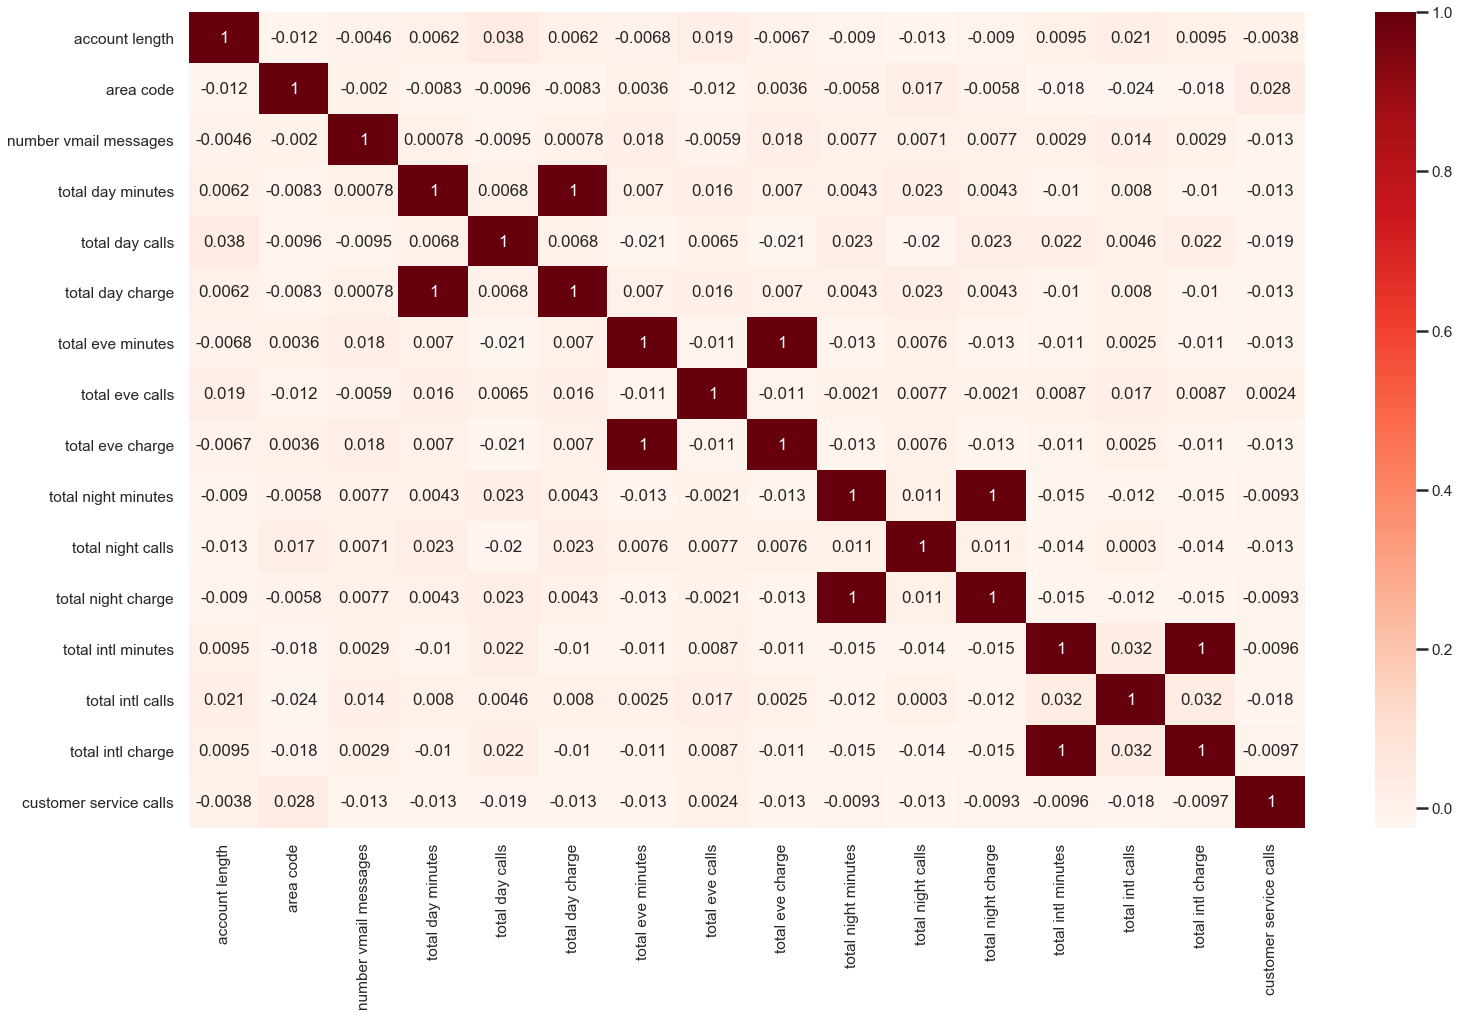

In [7]:
cl_f.colin_plt(df, target='churn', figsize=(25,15))

### Comments on Colinearity
- Minutes and Charges have a 1-to-1 relationship

In [8]:
print(df['churn'].value_counts())
print(df['churn'].value_counts(normalize=True))

False    2850
True      483
Name: churn, dtype: int64
False    0.855086
True     0.144914
Name: churn, dtype: float64


### Comments on Class Imbalance
- There is a class imbalance with respect to churn

## Feature Engineering and Selection

In [9]:
model_df = cl_f.ModelDF(df,
                        cat_features=['area code', 'state', 'international plan', 'voice mail plan'], 
                        target='churn')

In [10]:
# Categorize and drop cat_features
model_df.cat_and_drop()

---
Added dummies for and dropped "area code"
Added dummies for and dropped "state"
Added dummies for and dropped "international plan"
Added dummies for and dropped "voice mail plan"
Now has 70 columns


In [11]:
# Create a 'vm use' feature
model_df.new_cat('vm use', 'number vmail messages', 0, 'g')
model_df.df.head(3)

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,area code_415,area code_510,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international plan_yes,voice mail plan_yes,vm use
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# Train test split, resample, scale
model_df.preprocess(major=False, minor=True, samp_type=None, scaler=None)
model_df.info()

X and y acquired
Data has been split into train and test sets
No Resampling performed
No Scaling performed
---
Shape: (3333, 71)
There is/are 54 uint8 feature(s)
There is/are 8 int64 feature(s)
There is/are 8 float64 feature(s)
There is/are 1 bool feature(s)
---
Target Variable Class Ratios:
False    0.855086
True     0.144914
Name: churn, dtype: float64
Target Variable Counts:
False    2850
True      483
Name: churn, dtype: int64


## Model Fitting

### XGBoost w/ GridSearch CV

In [13]:
# XGBoost Classification Model
xgb_params = {'n_estimators': [150, 200, 300, 400],
              'learning_rate': [0.1, 0.09],
              'max_depth': [7, 8, 9],
              'colsample_bytree': [0.8],
              'min_child_weight': [1]}

model_df.get_xgb(gs=True, params=xgb_params, push_out=True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished


Accuracy: 0.959520
F1: 0.843931
Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.09, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 150}
---
Number of Features Removed: 24
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.3min finished


Accuracy After Push Out: 0.962519
F1 After Push Out: 0.853801
Best Parameters After Push Out:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200}


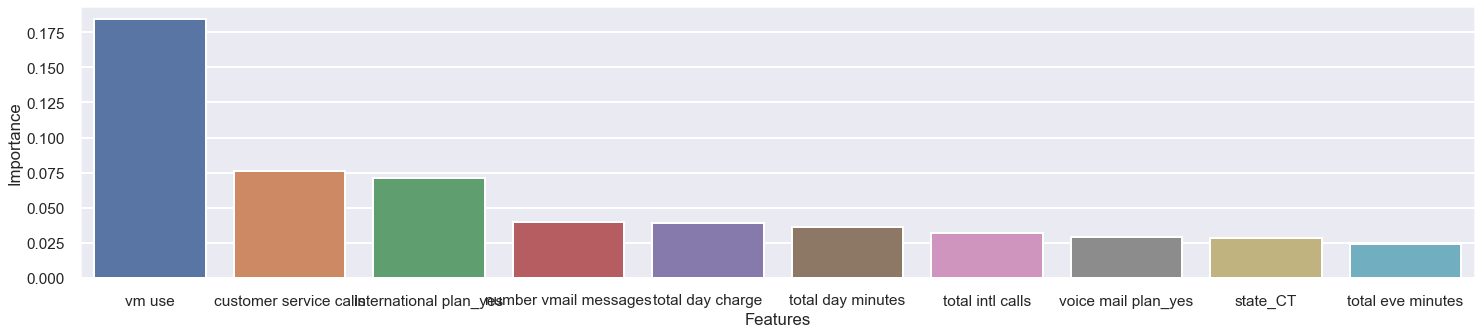

In [15]:
model_df.plot_bf()

### Comments on XGBoost
- Minutes seem to be the most important features (as seen by the LMPlots) along with customer service calls
- Total calls which also influence total minutes also seem to be important features

### RandomForest

In [16]:
rf_params = {'criterion': ['entropy'],
            'n_estimators': [150],
            'max_depth': [10],
            'max_features': ['auto'],
            'class_weight': ['balanced']}

model_df.get_rf(gs=True, params=rf_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Accuracy: 0.946027
F1: 0.790698
Best Parameters:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 150}


### Comments on RandomForest
- Not as "predictive" as XGBoost